# Notebook Imports

In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

%matplotlib inline

# Constants

In [2]:
EXAMPLE_FILE = 'Data/SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'Data/SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

SPAM_CAT = 1
HAM_CAT = 0

DATA_JSON_FILE = 'Data/SpamData/01_Processing/email-text-data.json'

In [3]:
stream = open(EXAMPLE_FILE)
message = stream.read()
stream.close()

# print(message)

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE)

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = '\n'.join(lines)
print(email_body)




Dear Mr Still



Good tidings to you and all your staff for the festive season ahead (Christmas).

Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.

But WAIT! You're probably thinking: "What makes him so special?"

Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.

You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.

I look forward to hearing from you.



Best wishes

Robin Cooper

[Excerpt from the book: The Timewaster Let

# Generator Functions

In [6]:
def generator_squares(N):
    for my_number in range(N):
        yield my_number**3

In [7]:
for i in generator_squares(3):
    print(i)

0
1
8


# Emails body Extractor

In [8]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for filename in filenames:
            
            filepath = join(root, filename)
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            yield filename, email_body

In [9]:
def df_from_directory (path, classification):
    rows = []
    row_names = []
    
    for filename, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(filename)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))

In [11]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))

In [12]:
print(spam_emails.shape)
print(ham_emails.shape)

(1898, 2)
(3901, 2)


In [13]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of data is:', data.shape)
data.head()


Shape of data is: (5799, 2)


,MESSAGE,CATEGORY
00001.7848dde101aa985090474a91ec93fcf0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1
00002.d94f1b97e48ed3b553b3508d116e6a09,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00003.2ee33bc6eacdb11f38d052c44819ba6c,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1
00004.eac8de8d759b7e74154f142194282724,##############################################...,1
00005.57696a39d7d84318ce497886896bf90d,I thought you might like these:\n\n1) Slim Dow...,1


# Data Cleaning: Checking for Missing Values

In [14]:
# Check for null emails
# data.MESSAGE
data['MESSAGE'].isnull().values.any()

False

In [15]:
data['MESSAGE'].isnull().sum()

0

In [16]:
# Check if there are empty emails
(data.MESSAGE.str.len() == 0).any()

True

In [17]:
(data.MESSAGE.str.len() == 0).sum()

3

In [18]:
data[data.MESSAGE.str.len() == 0]

,MESSAGE,CATEGORY
cmds,,1
cmds,,1
cmds,,0


In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.index.get_loc('cmds')

array([False, False, False, ..., False, False, False])

# Remove System File Entries from DataFrame

In [21]:
data.drop(['cmds'], inplace=True)

In [22]:
(data.MESSAGE.str.len() == 0).sum()

0

In [23]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [24]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids

In [25]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)

data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.0 Tr...",1,00001.7848dde101aa985090474a91ec93fcf0
1,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00002.d94f1b97e48ed3b553b3508d116e6a09
2,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00003.2ee33bc6eacdb11f38d052c44819ba6c
3,##############################################...,1,00004.eac8de8d759b7e74154f142194282724
4,I thought you might like these:\n\n1) Slim Dow...,1,00005.57696a39d7d84318ce497886896bf90d


In [26]:
data.tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5791,http://news.bbc.co.uk/1/hi/england/2515127.stm...,0,01396.61983fbe6ec43f55fd44e30fce24ffa6
5792,"> >-- be careful when using this one.) Also, t...",0,01397.9f9ef4c2a8dc012d80f2ce2d3473d3b7
5793,">>>>> ""SM"" == Skip Montanaro <skip@pobox.com> ...",0,01398.169b51731fe569f42169ae8f948ec676
5794,"So then, ""Mark Hammond"" <mhammond@skippinet.co...",0,01399.ca6b00b7b341bbde9a9ea3dd6a7bf896
5795,"Hi there,\n\n\n\nNow this is probably of no us...",0,01400.f897f0931e461e7b2e964d28e927c35e


# Save data to JSON file

In [27]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualized (Pie Charts)

In [28]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [29]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

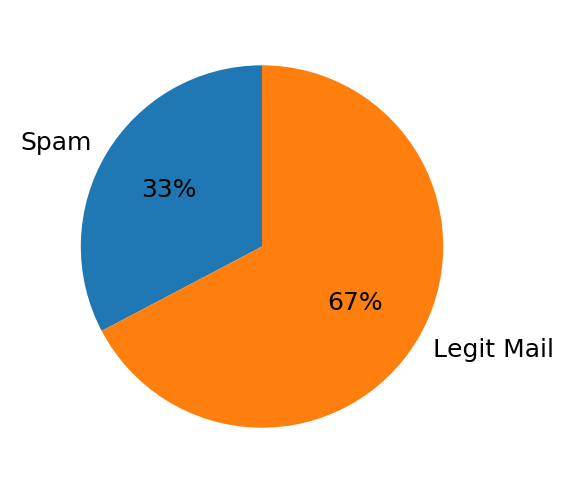

In [30]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%")
plt.show()

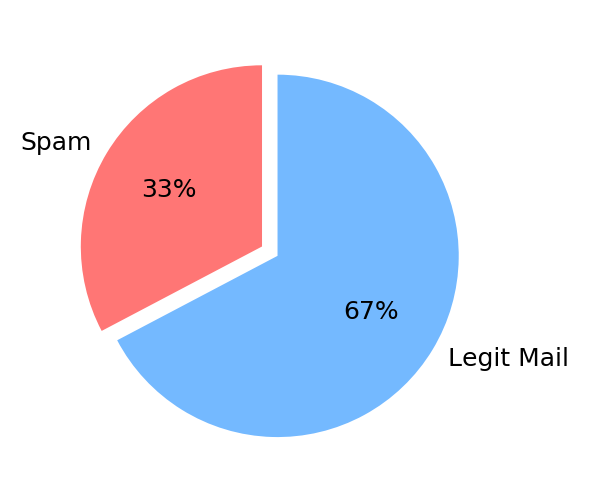

In [31]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%", colors=custom_colours, explode=[0, 0.1])
plt.show()

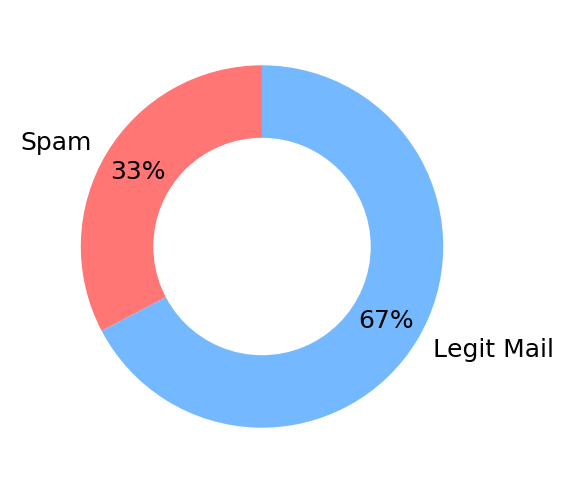

In [32]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%", colors=custom_colours, pctdistance=0.8)

#draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()


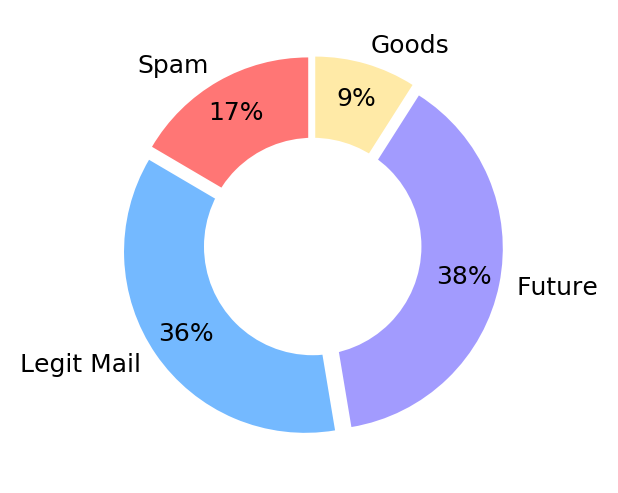

In [33]:
category_names = ['Spam', 'Legit Mail', 'Future', 'Goods']
sizes = [22, 48, 51, 12]
custom_colours = ['#ff7675', '#74b9ff', '#a29bfe', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(3, 3), dpi=200)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 9}, startangle=90,
       autopct="%1.0f%%", colors=custom_colours, pctdistance=0.8, explode=offset)

#draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()


# Natural Language Processing

### Text Pre-Processing

In [34]:
# convert to lowercase
msg = 'I am the Bond of my Swords'
msg.lower()

'i am the bond of my swords'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [35]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vinh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [36]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vinh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenising

In [37]:
msg = 'I am the Bond of my Swords'
word_tokenize(msg.lower())

['i', 'am', 'the', 'bond', 'of', 'my', 'swords']

### Removing Stopwords

In [38]:
stop_words = set(stopwords.words('english'))

In [39]:
type(stopwords.words('english'))

list

In [40]:
type(stop_words)

set

In [41]:
if 'alll' not in stop_words: 
    print('Nope')

Nope


In [42]:
if 'all' in stop_words: 
    print('Ok')

Ok


In [43]:
msg = 'I am the Bond of my Swords. Let it be'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['bond', 'swords', '.', 'let']


# Word Stemming

In [44]:
msg = 'I am the Bond of my Swords. Steel is my body. Let it be'
words = word_tokenize(msg.lower())
stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['bond', 'sword', '.', 'steel', 'bodi', '.', 'let']


# Removing Punctuation

In [45]:
'a'.isalpha()

True

In [46]:
'?'.isalpha()

False

In [48]:
msg = 'I am the Bond of my Swords. Steel is my body. Let it be???'
words = word_tokenize(msg.lower())
stemmer = PorterStemmer()

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['bond', 'sword', 'steel', 'bodi', 'let']
